# サポートベクターマシン

このHands-onでは下記2種類のデータを用いて，サポートベクターマシンについて体験する．

* 手書き数字画像（[第6章](/content/knn-and-ml-flow.ipynb)のHands-onでも用いたデータ）
* 人工的に作られたある2次元データ

Hands-onに先立って，必要なライブラリを読み込んでおこう．

In [1]:
# 表形式のデータを操作するためのライブラリ
import pandas as pd

# 行列計算をおこなうためのライブラリ
import numpy as np

# データセット
from sklearn import datasets

# K近傍法を実行するためのクラス
from sklearn.neighbors import KNeighborsClassifier

# 決定木を実行するためのクラス
from sklearn.tree import DecisionTreeClassifier

# サポートベクターマシンを実行するためのモジュール
from sklearn import svm

# データ変換のためのクラス
import sklearn.preprocessing as preprocessing

# 交差検証を行うためのクラス
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

# 評価指標（マクロ精度）
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score, precision_score

# グラフ描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

---
(L7-S1)=
## 例題1: MNIST手書き数字データ

例題1では，K近傍法のHands-onで用いた[MNISTデータセット](https://ja.wikipedia.org/wiki/MNIST%E3%83%87%E3%83%BC%E3%82%BF%E3%83%99%E3%83%BC%E3%82%B9)を用いて，手書き数字の識別するサポートベクターマシン分類器を構築しよう．
データセットの詳細は[前回のHands-on](/content/knn-and-ml-flow.ipynb)を参照のこと．

それでは，以下のコードを実行してMNISTデータセットを読み込もう．

In [2]:
mnist_dataset = datasets.load_digits()
X_mnist = mnist_dataset.data
y_mnist = mnist_dataset.target

前回の「K近傍法」の授業では，機械学習を実際に行う際には
* 前処理
* 学習･評価の流れ
* 評価手法

に関するお作法があることを学んだ．
K近傍法や機械学習のお作法の復習のために，まずはK近傍法を使ってMNISTの分類器の構築・評価を行ってみよう．
今回は5分割交差検証を行い，評価手法にはマクロ精度（Balanced Accuracy）を用いることにする．

下記コードは，MNISTデータセットにK近傍法を適用する例である．

In [3]:
# 5分割「層別化」交差検証の準備（乱数を固定）
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

# 評価指標（マクロ精度）
score_funcs = ['balanced_accuracy']

# K近傍法のモデルの定義（K=5で設定）
K = 5
knn_model = KNeighborsClassifier(n_neighbors=K, metric="euclidean")

# 交差検証をしながら分類器を構築・評価
results = cross_validate(knn_model, X_mnist, y_mnist, cv=k_fold, scoring=score_funcs)

# 交差検証の評価スコアを平均としてまとめる
print("Balanced accuracy: ", np.mean(results['test_balanced_accuracy']))

Balanced accuracy:  0.9870943800943801


マクロ精度は98.7\%程度になった．
K近傍法でも十分な分類性能を発揮することが分かる．

次はサポートベクターマシンで手書き数字画像の分類器を構築・評価してみよう．
機械学習万能ライブラリである`sklearn`は，サポートベクターマシンに関するクラスも提供している．
`sklearn`ではサポートベクターマシンに関連するクラスとして
* 分類問題を扱うための`svm.SVC`クラス
* 回帰問題を扱うための`svm.SVR`クラス

の2種類を提供している．
今回は分類問題を扱うので，`svm.SVC`クラスを用いる．
今回はカーネルトリックは使わず，単純な線形サポートベクターマシンを使ってみよう．

`sklearn`ライブラリを使えば，上のK近傍法コードをたった一行変えるだけで，サポートベクターマシンによる分類器の構築・評価ができてしまう．
以下，修正したコードを実行してみよう．

In [4]:
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)
score_funcs = ['balanced_accuracy']

# 線形サポートベクターマシン（ここが修正点）
svm_model = svm.SVC(kernel='linear')

results = cross_validate(svm_model, X_mnist, y_mnist, cv=k_fold, scoring=score_funcs)
print("Balanced accuracy: ", np.mean(results['test_balanced_accuracy']))

Balanced accuracy:  0.9787107780048956


サポートベクターマシンを用いたときのマクロ精度は98%程度になった．
MNISTデータセットの分類問題に関しては，サポートベクターマシンとK近傍法の性能は同程度のようだ．

---
(L7-Sec2)=
## 例題2: 線形分離不可能なデータに対するサポートベクターマシン

次の例題では，人工的な2次元データの分類問題を扱う．
まずは以下のコードを実行して，今回の例題で用いるデータを読み込もう．

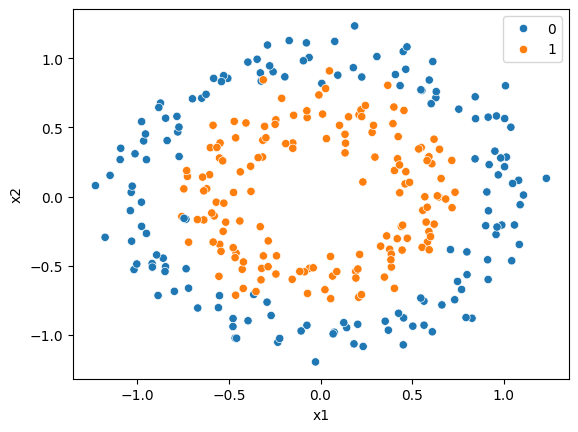

In [5]:
from sklearn.datasets import make_circles, make_moons
moons = make_circles(n_samples=300, noise=0.1, factor=0.6, random_state=777)

X_moon = moons[0]
y_moon = moons[1]

ax = sns.scatterplot(x=X_moon[:, 0], y=X_moon[:, 1], hue=y_moon)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.show()

今回用いるデータは，授業でも扱った「ドーナツ型」のデータ分布をしている．
内側にオレンジ色の点（ラベル1）が，外側に青色の点（ラベル0）が分布している．
これらデータを用いて，データがラベル1かラベル0かを分類する分類器を構築してみよう．

まず，線形SVMを用いて分類器を構築・評価してみよう．
以下のように例題1のコードをほぼそのまま流用することで，線形SVMの学習・評価ができる．

In [6]:
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

# 今回は評価指標として適合率（precision）と再現率（recall）を使用
score_funcs = ['precision_macro', 'recall_macro']

# 線形サポートベクターマシン（ここが修正点）
svm_model = svm.SVC(kernel='linear')

results = cross_validate(svm_model, X_moon, y_moon, cv=k_fold, scoring=score_funcs)
print("Precision: ", np.mean(results['test_precision_macro']))
print("Recall: ", np.mean(results['test_recall_macro']))

Precision:  0.4916286178314683
Recall:  0.49333333333333335


適合率も再現率も49\%なので，デタラメにラベルを答える場合とほぼ性能が分からないと言える．
授業でも説明したが，素のサポートベクターマシン（線形SVM）は，今回用いるデータセットのような**線形分離不可能**な分類問題にはうまく対応できない．
このような場合は，データを高次元に写像することでうまく対応できる可能性がある．

普通の流れならここでカーネルトリックを用いた非線形SVMを用いるのだが，少し寄り道をしよう．
手動でデータを高次元に写像し，そのデータに対して線形SVMを適用してみよう．

今回用いたデータは2次元データであった．
ここで，1次元目の要素を$x_1$，2次元目の要素を$x_2$としたとき，3次元目の要素として$\sqrt{x_1^2+x_2^2}$をデータに追加しよう．
以下はそのためのコードである．

In [7]:
X_moon_new = np.insert(X_moon, 2, np.sqrt(X_moon[:, 0]**2+X_moon[:, 1]**2), axis=1)

# データの末尾10件のみ表示
X_moon_new[-10:, :]

array([[ 0.22518032,  0.8642077 ,  0.89306278],
       [ 0.96372889, -0.22060904,  0.98865653],
       [ 0.38431474, -0.4575082 ,  0.59750445],
       [ 0.23280386, -1.08479306,  1.10949251],
       [ 0.54765035, -0.73467811,  0.91633664],
       [ 0.48637921,  0.10255874,  0.49707447],
       [-1.02809832,  0.07486352,  1.0308204 ],
       [-0.84914995, -0.54263203,  1.00772276],
       [-0.69927825,  0.70696368,  0.99437805],
       [-0.4580985 , -1.02554963,  1.12321248]])

3次元目の要素がデータに追加された．
新たに作った`X_new`を使って，再度サポートベクターマシンを適用してみよう．
以下，そのコード例である．

In [8]:
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)
score_funcs = ['precision_macro', 'recall_macro']
svm_model = svm.SVC(kernel='linear')

# XをX_newに修正
results = cross_validate(svm_model, X_moon_new, y_moon, cv=k_fold, scoring=score_funcs)
print("Precision: ", np.mean(results['test_precision_macro']))
print("Recall: ", np.mean(results['test_recall_macro']))

Precision:  0.9636484983314795
Recall:  0.9633333333333335


適合率も再現率も大幅に向上した．
今回のデータは円の形に分布していたので，3時限目のデータとして円の半径に相当するような要素を追加した．
それが功を奏して分類器の性能が向上した．

しかし，このような都合の良いの高次元写像をデータに応じて地力で見つけるのは容易ではない．
こんなときに有用なのが**カーネルトリックを用いた非線形SVM**である．
例題の締めとして，**RBFカーネルを用いた非線形SVM**による分類器の構築・評価を行ってみよう．

`sklearn`ライブラリを用いれば，非線形SVMも簡単に実行できてしまう．
今回はパラメータチューニングはせず，デフォルトの状態でRBFカーネルを用いてみよう．
以下のコードを実行して，（手動で高次元化していない）元のデータを用いた学習・評価を行ってみよう．

In [9]:
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)
score_funcs = ['precision_macro', 'recall_macro']

# カーネルにRBFカーネルを指定
svm_model = svm.SVC(kernel='rbf')

# 交差検証
results = cross_validate(svm_model, X_moon, y_moon, cv=k_fold, scoring=score_funcs)

print("Precision: ", np.mean(results['test_precision_macro']))
print("Recall: ", np.mean(results['test_recall_macro']))

Precision:  0.9638575268817204
Recall:  0.9633333333333335


データを手動で高次元空間に写像しなくても，RBFカーネルが良い具合に振る舞ってくれた．

---

## クイズ

※ 以下のクイズの回答にGoogle Colaboratoryを使いたい方は[コチラ](https://colab.research.google.com/github/hontolab-courses/ml-lecturenote/blob/main/content/quiz/svm.ipynb)をクリック．


(L7-Q1)=
### Q1: 実行時間の計測

機械学習モデルの交差検証を簡単に行ってくれる`sklearn`ライブラリの`cross_validate`関数は，その返値（辞書）には
- 学習の所要時間（`fit_time`）
- 評価（推論）の所要時間（`score_time`）

に関する情報が格納されている（[参考](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)）．

この情報を用いて，[例題1](#L7-S1)におけるMNIST分類器を
1. 多項式カーネル（`kernel='poly'`）を用いたサポートベクターマシン
2. K近傍法（`K=5`）
3. 決定木

の3つの機械学習手法で構築した際の

- 分類器の性能
- 分類器の構築（学習）にかかる時間
- 分類器の評価（推論）にかかる時間
    
について比較を行いなさい．

(L7-Q2)=
### Q2: 年収カテゴリ分類の性能比較

Q1で行った同様の比較を，[第6章](/content/knn-and-ml-flow.ipynb)のクイズで取り組んだ[年収カテゴリ分類問題](#L6-S3)に対して行いなさい．